# Blackjack Reinforcement Learning - Final Project
### Presented by:
* Michael Mutter

### Implements 4 RL approaches: **Basic Strategy, Monte Carlo, SARSA, and Deep Q-Network**

### Compares performance using adaptive betting strategies and comprehensive metrics.

* Note: Initial code structure generated with AI assistance, then modified and adapted for betting strategies, state representations, hyperparameters, and analysis tools.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import random
from typing import Tuple, List, Dict, Optional
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 1. Blackjack Environment

In [ ]:
# Blackjack Environment: Rules and Game Logic  & This section deals with all game mechanics.
class BlackjackEnvironment:
    """
    Advanced Blackjack environment.
    Complete game logic
    """

    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.max_bet = 2000
        self.min_bet = 10
        self.reset_shoe()

        # Split tracking for current round
        self.split_used = False

    def reset_shoe(self):
        """Reset and shuffle the shoe when exhausted"""
        # Create 6 decks (4 suits × 13 ranks × 6 decks = 312 cards)
        self.shoe = []
        for _ in range(self.num_decks):
            for suit in range(4):
                for rank in range(1, 14):
                    card_value = min(rank, 10)  # Face cards = 10, Ace = 1
                    self.shoe.append(card_value)
        random.shuffle(self.shoe)

    def draw_card(self):
        """Draw a card from the shoe"""
        if len(self.shoe) == 0:
            self.reset_shoe()
        card = self.shoe.pop()
        return card

    def get_hand_value(self, hand):
        """Calculate hand value with proper soft/hard ace logic"""
        value = sum(hand)
        num_aces = hand.count(1)

        # Try to use aces as 11 without busting
        while value <= 11 and num_aces > 0:
            value += 10
            num_aces -= 1
        return value

    def is_soft_hand(self, hand):
        """Check if hand contains an ace counted as 11"""
        if 1 not in hand:
            return False
        # Test if we can use an ace as 11 without busting
        total_hard = sum(hand)
        return total_hard + 10 <= 21

    def is_blackjack(self, hand):
        """Check if hand is natural blackjack (21 with exactly 2 cards)"""
        return len(hand) == 2 and self.get_hand_value(hand) == 21

    def can_double(self, hand):
        """Double only allowed on exactly 2 cards"""
        return len(hand) == 2

    def can_split(self, hand):
        """Split only when exactly 2 cards of same value AND not used yet"""
        return (len(hand) == 2 and
                hand[0] == hand[1] and
                not self.split_used)

    def play_dealer(self, dealer_hand):
        """Dealer plays according to rules: hit until 17+"""
        while self.get_hand_value(dealer_hand) < 17:
            dealer_hand.append(self.draw_card())
        return dealer_hand

    def calculate_reward(self, player_hand, dealer_hand, bet, is_doubled=False):
        """
        Calculate monetary reward for one hand
        Returns actual dollar amount won/lost
        """
        player_value = self.get_hand_value(player_hand)
        dealer_value = self.get_hand_value(dealer_hand)

        player_bj = self.is_blackjack(player_hand)
        dealer_bj = self.is_blackjack(dealer_hand)

        # Determine actual bet amount
        actual_bet = bet * 2 if is_doubled else bet

        # Handle blackjacks first
        if player_bj:
            if dealer_bj:
                return 0  # Push
            else:
                # Natural blackjack pays 1.5x (but not if doubled)
                return bet * 1.5 if not is_doubled else actual_bet

        if dealer_bj:
            return -actual_bet

        # Regular outcomes
        if player_value > 21:
            return -actual_bet  # Player bust
        elif dealer_value > 21:
            return actual_bet   # Dealer bust
        elif player_value > dealer_value:
            return actual_bet   # Player wins
        elif player_value == dealer_value:
            return 0            # Push
        else:
            return -actual_bet  # Dealer wins

    def step(self, action, player_hand, dealer_hand, bet, can_double=True, can_split=False):
        """
        Execute one step in the environment
        Actions: 0=stand, 1=hit, 2=double, 3=split
        Returns: player_hand, dealer_hand, reward, done
        """
        if action == 0:  # Stand
            dealer_hand = self.play_dealer(dealer_hand)
            reward = self.calculate_reward(player_hand, dealer_hand, bet)
            return player_hand, dealer_hand, reward, True

        elif action == 1:  # Hit
            player_hand.append(self.draw_card())
            if self.get_hand_value(player_hand) > 21:
                # Immediate bust
                return player_hand, dealer_hand, -bet, True
            return player_hand, dealer_hand, 0, False

        elif action == 2 and can_double:  # Double
            player_hand.append(self.draw_card())
            # Must stand after double
            dealer_hand = self.play_dealer(dealer_hand)
            reward = self.calculate_reward(player_hand, dealer_hand, bet, is_doubled=True)
            return player_hand, dealer_hand, reward, True

        elif action == 3 and can_split:  # Split
            # Return special indicator for split handling - but keep it boolean compatible
            return player_hand, dealer_hand, 0, 'split'

        # Invalid action, treat as stand
        return self.step(0, player_hand, dealer_hand, bet, False, False)

    def play_round(self, agent, bet, episode=0):
        """
        Play complete round with detailed state-action tracking for learning
        Returns: total_reward, game_info, learning_data
        """
        # Reset split flag for new round
        self.split_used = False

        # Track all state-action pairs for learning
        learning_data = {
            'states': [],
            'actions': [],
            'rewards': [],
            'next_states': [],
            'dones': []
        }

        # Deal initial cards
        player_hand = [self.draw_card(), self.draw_card()]
        dealer_hand = [self.draw_card(), self.draw_card()]
        dealer_up = dealer_hand[0]

        game_info = {
            'hands_played': 1,
            'split_occurred': False,
            'blackjack_occurred': False,
            'doubled': False
        }

        # Check for immediate blackjack
        if self.is_blackjack(player_hand):
            game_info['blackjack_occurred'] = True
            dealer_hand = self.play_dealer(dealer_hand)
            reward = self.calculate_reward(player_hand, dealer_hand, bet)

            # Even for immediate blackjack, record the "decision" state
            state = agent.get_state(player_hand, dealer_up, self)
            learning_data['states'].append(state)
            learning_data['actions'].append(0)  # Stand (implicit)
            learning_data['rewards'].append(reward)
            learning_data['next_states'].append(None)  # Terminal
            learning_data['dones'].append(True)

            return reward, game_info, learning_data

        # Get first action and handle accordingly
        if hasattr(agent, '_basic_strategy_action'):  # Learning agents with warm-up
            first_action = agent.get_action(player_hand, dealer_up, self,
                                          can_double=self.can_double(player_hand),
                                          can_split=self.can_split(player_hand),
                                          episode=episode)
        else:  # Basic strategy and DQN agents
            first_action = agent.get_action(player_hand, dealer_up, self,
                                          can_double=self.can_double(player_hand),
                                          can_split=self.can_split(player_hand))

        # Handle split
        if first_action == 3 and self.can_split(player_hand):
            return self._handle_split(agent, player_hand, dealer_hand, bet, episode, game_info, learning_data)

        # Regular single hand play
        return self._play_single_hand(agent, player_hand, dealer_hand, bet, episode, game_info, learning_data)

    def _handle_split(self, agent, player_hand, dealer_hand, bet, episode, game_info, learning_data):
        """Handle split logic with separate rewards for each hand"""
        self.split_used = True
        game_info['split_occurred'] = True
        game_info['hands_played'] = 2

        # Record the split decision - handle different agent types
        if hasattr(agent, 'get_state'):
            split_state = agent.get_state(player_hand, dealer_hand[0], self)
        elif hasattr(agent, 'get_state_vec'):
            split_state = agent.get_state_vec(player_hand, dealer_hand[0], self)
        else:
            # Fallback for basic strategy
            split_state = (self.get_hand_value(player_hand), dealer_hand[0],
                          self.is_soft_hand(player_hand), self.can_double(player_hand),
                          self.can_split(player_hand), len(player_hand),
                          min(9, int(agent.balance / 1_000_000)))

        split_decision_index = len(learning_data['states'])
        learning_data['states'].append(split_state)
        learning_data['actions'].append(3)  # Split action
        learning_data['rewards'].append(0)  # Will be updated with total
        learning_data['next_states'].append(None)
        learning_data['dones'].append(True)  # Split decision ends immediately

        # Create two hands from split
        hand1 = [player_hand[0], self.draw_card()]
        hand2 = [player_hand[1], self.draw_card()]

        total_reward = 0
        hand_rewards = []

        # Play each hand separately - each gets independent learning data
        for i, hand in enumerate([hand1, hand2]):
            # Create separate learning data for each split hand
            hand_learning_data = {'states': [], 'actions': [], 'rewards': [], 'next_states': [], 'dones': []}

            hand_reward, hand_info, _ = self._play_single_hand(
                agent, hand, dealer_hand.copy(), bet, episode,
                {'hands_played': 1, 'split_occurred': False, 'blackjack_occurred': False, 'doubled': False},
                hand_learning_data,
                is_split_hand=True
            )

            hand_rewards.append(hand_reward)
            total_reward += hand_reward

            # Each split hand gets its own reward - this is key for proper learning
            # Add the hand's learning data to main learning data
            learning_data['states'].extend(hand_learning_data['states'])
            learning_data['actions'].extend(hand_learning_data['actions'])
            learning_data['rewards'].extend(hand_learning_data['rewards'])
            learning_data['next_states'].extend(hand_learning_data['next_states'])
            learning_data['dones'].extend(hand_learning_data['dones'])

            if hand_info['doubled']:
                game_info['doubled'] = True
            if hand_info['blackjack_occurred']:
                game_info['blackjack_occurred'] = True

        # Update the split decision with total reward (for overall split evaluation)
        learning_data['rewards'][split_decision_index] = total_reward

        return total_reward, game_info, learning_data

    def _play_single_hand(self, agent, player_hand, dealer_hand, bet, episode, game_info, learning_data, is_split_hand=False):
        """Play a single hand with detailed state-action tracking"""
        done = False
        step_count = 0
        current_reward = 0

        while not done and step_count < 10:  # Prevent infinite loops
            step_count += 1

            # Get current state - handle different agent types
            if hasattr(agent, 'get_state'):
                current_state = agent.get_state(player_hand, dealer_hand[0], self)
            elif hasattr(agent, 'get_state_vec'):
                current_state = agent.get_state_vec(player_hand, dealer_hand[0], self)
            else:
                # Fallback for basic strategy
                current_state = (self.get_hand_value(player_hand), dealer_hand[0],
                               self.is_soft_hand(player_hand), self.can_double(player_hand),
                               self.can_split(player_hand), len(player_hand),
                               min(9, int(agent.balance / 1_000_000)))

            # Get action
            if hasattr(agent, '_basic_strategy_action'):  # Learning agents with warm-up
                action = agent.get_action(player_hand, dealer_hand[0], self,
                                        can_double=self.can_double(player_hand),
                                        can_split=False if is_split_hand else self.can_split(player_hand),
                                        episode=episode)
            else:  # Basic strategy and DQN agents
                action = agent.get_action(player_hand, dealer_hand[0], self,
                                        can_double=self.can_double(player_hand),
                                        can_split=False if is_split_hand else self.can_split(player_hand))

            # Execute action and get result
            new_player_hand, new_dealer_hand, step_reward, done = self.step(
                action, player_hand.copy(), dealer_hand.copy(), bet,
                can_double=self.can_double(player_hand),
                can_split=False if is_split_hand else self.can_split(player_hand)
            )

            # Handle split case - it should be handled at higher level
            if done == 'split':
                # This shouldn't happen in _play_single_hand, but handle it gracefully
                done = False
                step_reward = 0

            # Update hands
            player_hand = new_player_hand
            dealer_hand = new_dealer_hand

            # Get next state (if not terminal) - handle different agent types
            next_state = None
            if not done:
                if hasattr(agent, 'get_state'):
                    next_state = agent.get_state(player_hand, dealer_hand[0], self)
                elif hasattr(agent, 'get_state_vec'):
                    next_state = agent.get_state_vec(player_hand, dealer_hand[0], self)
                else:
                    # Fallback for basic strategy
                    next_state = (self.get_hand_value(player_hand), dealer_hand[0],
                                 self.is_soft_hand(player_hand), self.can_double(player_hand),
                                 self.can_split(player_hand), len(player_hand),
                                 min(9, int(agent.balance / 1_000_000)))

            # Record state-action-reward transition
            learning_data['states'].append(current_state)
            learning_data['actions'].append(action)
            learning_data['rewards'].append(step_reward if done else 0)  # Only terminal reward matters
            learning_data['next_states'].append(next_state)
            learning_data['dones'].append(done)

            if action == 2:  # Double was attempted
                game_info['doubled'] = True

            if done:
                current_reward = step_reward
                if self.is_blackjack(player_hand):
                    game_info['blackjack_occurred'] = True
                break

        # Fallback if loop didn't complete properly
        if not done:
            dealer_hand = self.play_dealer(dealer_hand)
            current_reward = self.calculate_reward(player_hand, dealer_hand, bet)

            # Record final state if needed
            if learning_data['states']:
                learning_data['rewards'][-1] = current_reward
                learning_data['dones'][-1] = True

        return current_reward, game_info, learning_data

# 2. Player Agents

## 2.1. Basic Strategy Agent

In [ ]:
class BasicStrategyAgent:
    """Agent 1: basic strategy implementation"""

    def __init__(self, initial_balance):
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.wins = 0
        self.losses = 0
        self.pushes = 0
        self.games_played = 0
        self.split_hands = 0
        self.blackjacks = 0
        self.history = []
        self.total_wagered = 0  # Track total money wagered

    def get_state(self, player_hand, dealer_up, env):
        """State representation for basic strategy (not used for decisions)"""
        player_value = env.get_hand_value(player_hand)
        is_soft = env.is_soft_hand(player_hand)
        can_double = env.can_double(player_hand)
        can_split = env.can_split(player_hand)
        hand_size = len(player_hand)
        balance_bucket = min(9, int(self.balance / 1_000_000))

        return (player_value, dealer_up, is_soft, can_double, can_split, hand_size, balance_bucket)

    def get_action(self, player_hand, dealer_up, env, can_double=True, can_split=False):
        """basic strategy decisions"""
        player_value = env.get_hand_value(player_hand)
        is_soft = env.is_soft_hand(player_hand)

        # Splitting strategy
        if can_split and env.can_split(player_hand):
            pair_value = player_hand[0]
            if pair_value == 1 or pair_value == 8:  # Always split Aces and 8s
                return 3
            elif pair_value == 10:  # Never split 10s
                return 0
            elif pair_value in [2, 3, 7]:
                return 3 if dealer_up <= 7 else 1
            elif pair_value == 6:
                return 3 if dealer_up <= 6 else 1
            elif pair_value in [4, 5]:
                return 1  # Never split 4s and 5s
            elif pair_value == 9:
                return 3 if dealer_up not in [7, 10, 1] else 0

        # Soft hand strategy
        if is_soft:
            if player_value >= 19:
                return 0  # Stand
            elif player_value == 18:
                if dealer_up in [2, 7, 8]:
                    return 0
                elif dealer_up in [3, 4, 5, 6] and can_double:
                    return 2
                else:
                    return 1
            elif player_value == 17:
                return 2 if (dealer_up in [3, 4, 5, 6] and can_double) else 1
            elif player_value in [15, 16]:
                return 2 if (dealer_up in [4, 5, 6] and can_double) else 1
            else:
                return 2 if (dealer_up in [5, 6] and can_double) else 1

        # Hard hand strategy
        if player_value >= 17:
            return 0  # Stand
        elif player_value <= 11:
            return 2 if can_double and len(player_hand) == 2 else 1
        elif player_value == 12:
            return 1 if dealer_up in [2, 3, 7, 8, 9, 10, 1] else 0
        elif player_value in [13, 14, 15, 16]:
            return 1 if dealer_up >= 7 or dealer_up == 1 else 0

        return 0  # Default stand

    def get_bet(self, env, episode=0):
        return min(150, self.balance)

    def update(self, *args):
        """No learning for basic strategy"""
        pass


## 2.2. ε-greedy MC Agent

In [ ]:
class EpsilonGreedyMCAgent:
    """Agent 2: Monte Carlo with ε-greedy exploration"""

    def __init__(self, initial_balance, epsilon=0.15):
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9999
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.returns = defaultdict(list)
        self.wins = 0
        self.losses = 0
        self.pushes = 0
        self.games_played = 0
        self.split_hands = 0
        self.blackjacks = 0
        self.history = []
        self.episode_memory = []
        self.recent_returns = deque(maxlen=1000)
        self.total_wagered = 0  # Track total money wagered

    def get_state(self, player_hand, dealer_up, env):
        """Clean state representation - core Blackjack features only"""
        player_value = env.get_hand_value(player_hand)
        is_soft = env.is_soft_hand(player_hand)
        can_double = env.can_double(player_hand)
        can_split = env.can_split(player_hand)
        hand_size = len(player_hand)

        # Discretize balance for Q-table efficiency
        balance_bucket = min(9, int(self.balance / 1_000_000))

        return (player_value, dealer_up, is_soft, can_double, can_split, hand_size, balance_bucket)

    def get_action(self, player_hand, dealer_up, env, can_double=True, can_split=False, episode=0):
        """
        ε-greedy action selection with basic strategy warm-up
        First 25,000 episodes: Use basic strategy for action selection
        After 25,000 episodes: Switch to ε-greedy exploration
        """
        state = self.get_state(player_hand, dealer_up, env)

        # WARM-UP PHASE: Use basic strategy for first 25,000 episodes
        if episode < 25000:
            return self._basic_strategy_action(player_hand, dealer_up, env, can_double, can_split)

        # LEARNING PHASE: ε-greedy action selection
        # Valid actions based on current situation
        valid_actions = [0, 1]  # Stand, Hit
        if can_double and env.can_double(player_hand):
            valid_actions.append(2)
        if can_split and env.can_split(player_hand):
            valid_actions.append(3)

        if random.random() < self.epsilon:
            # Exploration
            return random.choice(valid_actions)
        else:
            # Exploitation
            action_values = self.q_table[state]
            if not action_values:
                return random.choice(valid_actions)

            # Choose best valid action
            valid_q_values = {a: action_values.get(a, 0) for a in valid_actions}
            return max(valid_q_values, key=valid_q_values.get)

    def _basic_strategy_action(self, player_hand, dealer_up, env, can_double=True, can_split=False):
        """
        Basic strategy decision logic (copied from BasicStrategyAgent)
        Used during warm-up phase for learning agents
        """
        player_value = env.get_hand_value(player_hand)
        is_soft = env.is_soft_hand(player_hand)

        # Splitting strategy
        if can_split and env.can_split(player_hand):
            pair_value = player_hand[0]
            if pair_value == 1 or pair_value == 8:  # Always split Aces and 8s
                return 3
            elif pair_value == 10:  # Never split 10s
                return 0
            elif pair_value in [2, 3, 7]:
                return 3 if dealer_up <= 7 else 1
            elif pair_value == 6:
                return 3 if dealer_up <= 6 else 1
            elif pair_value in [4, 5]:
                return 1  # Never split 4s and 5s
            elif pair_value == 9:
                return 3 if dealer_up not in [7, 10, 1] else 0

        # Soft hand strategy
        if is_soft:
            if player_value >= 19:
                return 0  # Stand
            elif player_value == 18:
                if dealer_up in [2, 7, 8]:
                    return 0
                elif dealer_up in [3, 4, 5, 6] and can_double:
                    return 2
                else:
                    return 1
            elif player_value == 17:
                return 2 if (dealer_up in [3, 4, 5, 6] and can_double) else 1
            elif player_value in [15, 16]:
                return 2 if (dealer_up in [4, 5, 6] and can_double) else 1
            else:
                return 2 if (dealer_up in [5, 6] and can_double) else 1

        # Hard hand strategy
        if player_value >= 17:
            return 0  # Stand
        elif player_value <= 11:
            return 2 if can_double and len(player_hand) == 2 else 1
        elif player_value == 12:
            return 1 if dealer_up in [2, 3, 7, 8, 9, 10, 1] else 0
        elif player_value in [13, 14, 15, 16]:
            return 1 if dealer_up >= 7 or dealer_up == 1 else 0

        return 0  # Default stand

    def get_bet(self, env, episode=0):
        """Betting strategy based on average return per bet"""
        # Conservative phase for first 25,000 episodes
        if episode < 25000:
            return min(120, self.balance)

        base_bet = 150

        # Q-table confidence measure
        total_states = len(self.q_table)
        if total_states > 1000:
            confidence_multiplier = min(1.4, total_states / 1200)
        elif total_states > 500:
            confidence_multiplier = 1.1
        else:
            confidence_multiplier = 0.8

        # Performance-based adjustment using average return per bet
        if len(self.recent_returns) > 100:
            avg_return_per_bet = sum(self.recent_returns) / len(self.recent_returns)

            if avg_return_per_bet > 10:  # Good positive average
                performance_multiplier = 1.3
            elif avg_return_per_bet > 0:  # Slightly positive
                performance_multiplier = 1.1
            elif avg_return_per_bet > -10:  # Small losses
                performance_multiplier = 0.9
            else:  # Larger losses
                performance_multiplier = 0.7
        else:
            performance_multiplier = 1.0

        bet = int(base_bet * confidence_multiplier * performance_multiplier)
        max_bet = getattr(env, 'max_bet', 2000)
        return min(max(bet, 50), min(500, self.balance))

    def record_result(self, bet, reward):
        """Record result for betting strategy calculation"""
        self.recent_returns.append(reward)

    def store_experience(self, state, action, reward):
        """Store experience for Monte Carlo update"""
        self.episode_memory.append((state, action, reward))

    def update(self, learning_data):
        """Monte Carlo update with detailed episode data"""
        if not learning_data['states']:
            return

        # Extract episode data
        states = learning_data['states']
        actions = learning_data['actions']
        rewards = learning_data['rewards']

        # Calculate returns (work backwards)
        G = 0
        visited = set()

        for i in reversed(range(len(states))):
            state = states[i]
            action = actions[i]
            reward = rewards[i]

            G = reward + G  # Accumulate return

            # First-visit Monte Carlo
            if (state, action) not in visited:
                visited.add((state, action))
                self.returns[(state, action)].append(G)
                # Update Q-value with incremental mean
                self.q_table[state][action] = np.mean(self.returns[(state, action)])

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

## 2.3. SARSA (TD) Agent

In [ ]:
class TDAgent:
    """Agent 3: SARSA (on-policy TD)"""

    def __init__(self, initial_balance, learning_rate=0.15, epsilon=0.15):
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.alpha = learning_rate
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9999
        self.gamma = 1.0  # No discounting for episodic task
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.wins = 0
        self.losses = 0
        self.pushes = 0
        self.games_played = 0
        self.split_hands = 0
        self.blackjacks = 0
        self.history = []
        self.recent_returns = deque(maxlen=1000)  # Track recent returns
        self.total_wagered = 0  # Track total money wagered

    def get_state(self, player_hand, dealer_up, env):
        player_value = env.get_hand_value(player_hand)
        is_soft = env.is_soft_hand(player_hand)
        can_double = env.can_double(player_hand)
        can_split = env.can_split(player_hand)
        hand_size = len(player_hand)

        # Balance discretization
        balance_bucket = min(9, int(self.balance / 1_000_000))

        return (player_value, dealer_up, is_soft, can_double, can_split, hand_size, balance_bucket)

    def get_action(self, player_hand, dealer_up, env, can_double=True, can_split=False, episode=0):
        """
        ε-greedy action selection with basic strategy warm-up
        First 20,000 episodes: Use basic strategy for action selection
        After 20,000 episodes: Switch to ε-greedy exploration
        """
        state = self.get_state(player_hand, dealer_up, env)

        # WARM-UP PHASE: Use basic strategy for first 20,000 episodes
        if episode < 20000:
            return self._basic_strategy_action(player_hand, dealer_up, env, can_double, can_split)

        # LEARNING PHASE: ε-greedy action selection
        valid_actions = [0, 1]  # Stand, Hit
        if can_double and env.can_double(player_hand):
            valid_actions.append(2)
        if can_split and env.can_split(player_hand):
            valid_actions.append(3)

        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            action_values = self.q_table[state]
            if not action_values:
                return random.choice(valid_actions)

            valid_q_values = {a: action_values.get(a, 0) for a in valid_actions}
            return max(valid_q_values, key=valid_q_values.get)

    def _basic_strategy_action(self, player_hand, dealer_up, env, can_double=True, can_split=False):
        """
        Basic strategy decision logic (copied from BasicStrategyAgent)
        Used during warm-up phase for learning agents
        """
        player_value = env.get_hand_value(player_hand)
        is_soft = env.is_soft_hand(player_hand)

        # Splitting strategy
        if can_split and env.can_split(player_hand):
            pair_value = player_hand[0]
            if pair_value == 1 or pair_value == 8:  # Always split Aces and 8s
                return 3
            elif pair_value == 10:  # Never split 10s
                return 0
            elif pair_value in [2, 3, 7]:
                return 3 if dealer_up <= 7 else 1
            elif pair_value == 6:
                return 3 if dealer_up <= 6 else 1
            elif pair_value in [4, 5]:
                return 1  # Never split 4s and 5s
            elif pair_value == 9:
                return 3 if dealer_up not in [7, 10, 1] else 0

        # Soft hand strategy
        if is_soft:
            if player_value >= 19:
                return 0  # Stand
            elif player_value == 18:
                if dealer_up in [2, 7, 8]:
                    return 0
                elif dealer_up in [3, 4, 5, 6] and can_double:
                    return 2
                else:
                    return 1
            elif player_value == 17:
                return 2 if (dealer_up in [3, 4, 5, 6] and can_double) else 1
            elif player_value in [15, 16]:
                return 2 if (dealer_up in [4, 5, 6] and can_double) else 1
            else:
                return 2 if (dealer_up in [5, 6] and can_double) else 1

        # Hard hand strategy
        if player_value >= 17:
            return 0  # Stand
        elif player_value <= 11:
            return 2 if can_double and len(player_hand) == 2 else 1
        elif player_value == 12:
            return 1 if dealer_up in [2, 3, 7, 8, 9, 10, 1] else 0
        elif player_value in [13, 14, 15, 16]:
            return 1 if dealer_up >= 7 or dealer_up == 1 else 0

        return 0  # Default stand

    def get_bet(self, env, episode=0):
        """Betting strategy based on average return per bet"""
        # Conservative phase
        if episode < 20000:
            return min(120, self.balance)

        base_bet = 150

        # Q-table development indicator
        total_states = len(self.q_table)
        if total_states > 1200:
            learning_multiplier = 1.3
        elif total_states > 800:
            learning_multiplier = 1.15
        else:
            learning_multiplier = 0.9

        # Performance-based adjustment using average return per bet
        if len(self.recent_returns) > 100:
            avg_return = sum(self.recent_returns) / len(self.recent_returns)

            if avg_return > 15:  # Excellent performance
                performance_multiplier = 1.4
            elif avg_return > 5:  # Good performance
                performance_multiplier = 1.2
            elif avg_return > -5:  # Break-even
                performance_multiplier = 1.0
            else:  # Poor performance
                performance_multiplier = 0.8
        else:
            performance_multiplier = 1.0

        bet = int(base_bet * learning_multiplier * performance_multiplier)
        max_bet = getattr(env, 'max_bet', 2000)
        return min(max(bet, 50), min(400, self.balance))

    def record_result(self, bet, reward):
        """Record result for betting strategy calculation"""
        self.recent_returns.append(reward)

    def update(self, learning_data):
        """SARSA update with detailed state-action transitions"""
        if not learning_data['states']:
            return

        states = learning_data['states']
        actions = learning_data['actions']
        rewards = learning_data['rewards']
        next_states = learning_data['next_states']
        dones = learning_data['dones']

        # Update each state-action pair
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            reward = rewards[i]
            done = dones[i]

            current_q = self.q_table[state][action]

            if done:
                target = reward
            else:
                # For SARSA, we need the next action that would be taken
                if i + 1 < len(states):
                    next_state = next_states[i]
                    next_action = actions[i + 1]  # Actual next action taken
                    next_q = self.q_table[next_state][next_action]
                    target = reward + self.gamma * next_q
                else:
                    target = reward

            # SARSA update
            self.q_table[state][action] += self.alpha * (target - current_q)

        # Decay epsilon only once per episode
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

## 2.4. DQN Agent

In [ ]:
class NeuralNetworkAgent:
    """Agent 4: Deep Q-Network"""

    def __init__(self, initial_balance, learning_rate=0.001, epsilon=0.25):
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9999
        self.wins = 0
        self.losses = 0
        self.pushes = 0
        self.games_played = 0
        self.split_hands = 0
        self.blackjacks = 0
        self.history = []
        self.total_wagered = 0  # Track total money wagered

        # Neural network setup
        self.input_size = 7
        self.q_network = self.build_network()
        self.target_network = self.build_network()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = deque(maxlen=10000)
        self.batch_size = 32
        self.update_target_every = 100
        self.steps = 0

    def build_network(self):
        """Build deep Q-network"""
        return nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)  # 4 actions: stand, hit, double, split
        )

    def get_state(self, player_hand, dealer_up, env):
        """State representation compatibility method for DQN"""
        return self.get_state_vec(player_hand, dealer_up, env)

    def get_state_vec(self, player_hand, dealer_up, env):
        player_value = env.get_hand_value(player_hand)
        is_soft = float(env.is_soft_hand(player_hand))
        can_double = float(env.can_double(player_hand))
        can_split = float(env.can_split(player_hand))
        hand_size = len(player_hand)

        # Normalize balance
        balance_normalized = min(1.0, self.balance / 20000000)

        return np.array([
            player_value / 21.0,    # Normalize player value
            dealer_up / 10.0,       # Normalize dealer up card
            is_soft,                # Boolean features
            can_double,
            can_split,
            hand_size / 5.0,        # Normalize hand size
            balance_normalized      # Normalized balance
        ], dtype=np.float32)

    def get_action(self, player_hand, dealer_up, env, can_double=True, can_split=False):
        """ε-greedy action selection using neural network"""
        valid_actions = [0, 1]  # Stand, Hit
        if can_double and env.can_double(player_hand):
            valid_actions.append(2)
        if can_split and env.can_split(player_hand):
            valid_actions.append(3)

        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        state = self.get_state_vec(player_hand, dealer_up, env)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            q_values = self.q_network(state_tensor)

        # Mask invalid actions
        q_values_masked = q_values.clone()
        for action in range(4):
            if action not in valid_actions:
                q_values_masked[0][action] = -float('inf')

        return q_values_masked.argmax().item()

    def get_bet(self, env, episode=0):
        # Conservative phase
        if episode <10000:
            return min(120, self.balance)

        base_bet = 150

        # Network confidence based on training progress
        if self.steps > 5000:
            network_confidence = min(1.5, self.steps / 8000)
        else:
            network_confidence = 0.8

        # Performance adjustment
        if self.games_played > 1000:
            win_rate = self.wins / self.games_played
            if win_rate > 0.46:
                performance_multiplier =1.4
            elif win_rate > 0.42:
                performance_multiplier = 1.1
            else:
                performance_multiplier = 0.7
        else:
            performance_multiplier = 1.0

        bet = int(base_bet * network_confidence * performance_multiplier)
        max_bet = getattr(env, 'max_bet', 2000)  # Safe access to max_bet
        return min(max(bet, 50), min(max_bet, self.balance))

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Train the network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        # Separate terminal and non-terminal transitions
        non_terminal_mask = []
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []

        for experience in batch:
            state, action, reward, next_state, done = experience
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            # Convert done to boolean - handle 'split' case
            if done == 'split':
                done_bool = False  # Split is not terminal
            else:
                done_bool = bool(done)
            dones.append(done_bool)

            if next_state is not None and not done_bool:
                next_states.append(next_state)
                non_terminal_mask.append(True)
            else:
                # For terminal states, use zeros as placeholder
                next_states.append(np.zeros_like(state))
                non_terminal_mask.append(False)

        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        non_terminal_mask = torch.BoolTensor(non_terminal_mask)

        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Next Q values (only for non-terminal states)
        next_q_values = torch.zeros(self.batch_size)
        if non_terminal_mask.any():
            with torch.no_grad():
                next_q_values[non_terminal_mask] = self.target_network(next_states[non_terminal_mask]).max(1)[0]

        # Calculate target Q values
        target_q_values = rewards + (1 - dones) * next_q_values

        # Calculate loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.update_target_every == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update(self, learning_data):
        """
        DQN update optimized for maximum profit learning
        Learns from all transitions to understand deep patterns
        """
        if not learning_data['states']:
            return

        states = learning_data['states']
        actions = learning_data['actions']
        rewards = learning_data['rewards']
        next_states = learning_data['next_states']
        dones = learning_data['dones']

        # Store all transitions in replay memory for rich learning
        for i in range(len(states)):
            # Handle state conversion - DQN already gets state vectors
            if isinstance(states[i], np.ndarray):
                state_vector = states[i]  # Already a vector
            else:
                state_vector = self._convert_state_to_vector(states[i])  # Convert tuple to vector

            # Handle next state conversion
            if next_states[i] is None:
                next_state_vector = None
            elif isinstance(next_states[i], np.ndarray):
                next_state_vector = next_states[i]  # Already a vector
            else:
                next_state_vector = self._convert_state_to_vector(next_states[i])  # Convert tuple to vector

            # For DQN, we want to learn from every decision, especially:
            # 1. Terminal rewards (most important)
            # 2. Intermediate decisions that lead to good/bad outcomes
            # 3. Split decisions and their consequences

            reward = rewards[i]

            # Enhanced reward shaping for better learning:
            # Give extra weight to terminal positive outcomes
            if dones[i] and reward > 0:
                reward *= 1.1  # Slight boost for winning outcomes

            self.remember(state_vector, actions[i], reward, next_state_vector, dones[i])

        # More frequent learning for faster convergence
        if len(self.memory) >= self.batch_size:
            self.replay()
            # Extra replay for important episodes (big wins/losses)
            total_episode_reward = sum(rewards)
            if abs(total_episode_reward) > 100:  # Significant outcome
                self.replay()  # Learn twice from important episodes

    def _convert_state_to_vector(self, state_tuple):
        """Helper method to convert state tuple to vector format for neural network"""
        if state_tuple is None:
            return None

        # Extract components from state tuple
        player_value, dealer_up, is_soft, can_double, can_split, hand_size, balance_bucket = state_tuple

        # Create vector representation
        balance_normalized = balance_bucket / 9.0  # Normalize balance bucket

        return np.array([
            player_value / 21.0,
            dealer_up / 10.0,
            float(is_soft),
            float(can_double),
            float(can_split),
            hand_size / 5.0,
            balance_normalized
        ], dtype=np.float32)


# 3. Agents Training

In [ ]:
def train_agents(num_episodes):
    """Main training loop - UPDATED VERSION"""
    env = BlackjackEnvironment(num_decks=6)

    # Initialize all 4 agents
    initial_balance = 10_000_000
    agents = {
        'Basic Strategy': BasicStrategyAgent(initial_balance),
        'ε-greedy MC': EpsilonGreedyMCAgent(initial_balance, epsilon=0.15),
        'SARSA (TD)': TDAgent(initial_balance, learning_rate=0.15, epsilon=0.15),
        'Deep Q-Network': NeuralNetworkAgent(initial_balance, epsilon=0.25)
    }

    # Training history
    history = {name: {'balance': [initial_balance], 'wins': [], 'roi': []}
               for name in agents.keys()}

    print(f"Starting training for {num_episodes:,} episodes...")
    print("Pure strategy learning")
    print(f"Agents: {list(agents.keys())}")
    print("\n🎯 UPDATED STRATEGY:")
    print("- Episodes 0-24,999: MC agent uses Basic Strategy decisions")
    print("- Episodes 0-19,999: SARSA agent uses Basic Strategy decisions")
    print("- Episodes 25,000+: MC switches to ε-greedy exploration")
    print("- Episodes 20,000+: SARSA switches to ε-greedy exploration")
    print("- Betting based on average return per bet")
    print("- Conservative multipliers and exploration rates")

    for episode in range(num_episodes):
        # Each agent plays one round per episode
        for agent_name, agent in agents.items():
            if agent.balance <= 0:
                continue

            # Get bet amount
            bet = min(agent.get_bet(env, episode), agent.balance)
            if bet <= 0:
                continue

            # Play complete round using updated environment method
            total_reward, game_info, learning_data = env.play_round(agent, bet, episode)

            # Track total wagered amount (after we know if split occurred)
            if game_info.get('split_occurred', False):
                agent.total_wagered += bet * 2  # Split uses double the bet
            else:
                agent.total_wagered += bet

            # Update agent balance and statistics
            agent.balance += total_reward
            agent.games_played += 1

            # Record result for betting strategy (MC and SARSA only)
            if hasattr(agent, 'record_result'):
                agent.record_result(bet, total_reward)

            # Update win/loss statistics
            if total_reward > 0:
                agent.wins += 1
            elif total_reward < 0:
                agent.losses += 1
            else:
                agent.pushes += 1

            # Track special events
            if game_info['split_occurred']:
                agent.split_hands += 1
            if game_info['blackjack_occurred']:
                agent.blackjacks += 1

            # Learning updates for each agent type using detailed learning data
            if isinstance(agent, EpsilonGreedyMCAgent):
                agent.update(learning_data)

            elif isinstance(agent, TDAgent):
                agent.update(learning_data)

            elif isinstance(agent, NeuralNetworkAgent):
                agent.update(learning_data)

        # Record progress every 1000 episodes
        if episode % 1000 == 0:
            for name, agent in agents.items():
                history[name]['balance'].append(agent.balance)
                history[name]['wins'].append(agent.wins)
                roi = ((agent.balance - initial_balance) / initial_balance) * 100
                history[name]['roi'].append(roi)

        # Progress update
        if episode % 10000 == 0:
            print(f"Episode {episode:,}/{num_episodes:,}")
            for name, agent in agents.items():
                roi = ((agent.balance - initial_balance) / initial_balance) * 100
                win_rate = agent.wins / agent.games_played * 100 if agent.games_played > 0 else 0
                epsilon_str = f", ε={agent.epsilon:.4f}" if hasattr(agent, 'epsilon') else ""

                # Add warm-up indicator for learning agents
                warm_up_str = ""
                if hasattr(agent, '_basic_strategy_action'):
                    if (name == 'ε-greedy MC' and episode < 25000) or \
                       (name == 'SARSA (TD)' and episode < 20000):
                        warm_up_str = " [WARM-UP: Basic Strategy]"
                    elif (name == 'ε-greedy MC' and episode == 25000) or \
                         (name == 'SARSA (TD)' and episode == 20000):
                        warm_up_str = " [SWITCHING TO ε-GREEDY]"

                print(f"  {name}: ${agent.balance:,.0f} (ROI: {roi:+.1f}%, "
                      f"Win Rate: {win_rate:.1f}%{epsilon_str}){warm_up_str}")

                # Show Q-table development for learning agents
                if hasattr(agent, 'q_table'):
                    states = len(agent.q_table)
                    print(f"    Q-Table States: {states:,}")

            # messages at transition episodes
            if episode == 25000:
                print("  🎯 MC agent switching from Basic Strategy to ε-greedy exploration!")
            elif episode == 20000:
                print("  🎯 SARSA agent switching from Basic Strategy to ε-greedy exploration!")

    return agents, history, env

# 4. Results Visualization

In [ ]:
def visualize_results(agents, history):
    """Create comprehensive visualizations - UPDATED WITH TOTAL WAGERED"""
    plt.figure(figsize=(20, 12))  # EXPANDED: Larger figure for 6 subplots

    # 1. Balance over time
    plt.subplot(2, 3, 1)  # CHANGED: Now 2x3 grid
    for name in history.keys():
        episodes = np.arange(0, len(history[name]['balance'])) * 1000
        plt.plot(episodes, history[name]['balance'], label=name, linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Balance ($)')
    plt.title('Agent Balance Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ticklabel_format(style='plain', axis='y')

    # 2. ROI comparison
    plt.subplot(2, 3, 2)  # CHANGED: Now 2x3 grid
    for name in history.keys():
        episodes = np.arange(0, len(history[name]['roi'])) * 1000
        plt.plot(episodes, history[name]['roi'], label=name, linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('ROI (%)')
    plt.title('Return on Investment')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    # 3. Win rate comparison
    plt.subplot(2, 3, 3)  # CHANGED: Now 2x3 grid
    names = list(agents.keys())
    win_rates = []
    for agent in agents.values():
        total_games = agent.wins + agent.losses + agent.pushes
        win_rate = agent.wins / total_games * 100 if total_games > 0 else 0
        win_rates.append(win_rate)

    bars = plt.bar(names, win_rates, color=['blue', 'green', 'red', 'orange'])
    plt.ylabel('Win Rate (%)')
    plt.title('Final Win Rates')
    plt.xticks(rotation=45)

    for bar, rate in zip(bars, win_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom')

    # 4. NEW: Total Money Wagered Comparison
    plt.subplot(2, 3, 4)
    names = list(agents.keys())
    total_wagered = [agent.total_wagered for agent in agents.values()]

    bars = plt.bar(names, total_wagered, color=['blue', 'green', 'red', 'orange'])
    plt.ylabel('Total Wagered ($)')
    plt.title('Total Money Wagered Throughout All Episodes')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, amount in zip(bars, total_wagered):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_wagered)*0.01,
                f'${amount/1_000_000:.1f}M', ha='center', va='bottom', fontweight='bold')

    plt.ticklabel_format(style='plain', axis='y')

    # 5. NEW: Betting Efficiency (ROI per Dollar Wagered)
    plt.subplot(2, 3, 5)
    names = list(agents.keys())
    betting_efficiency = []
    initial_balance = 10_000_000

    for agent in agents.values():
        roi = ((agent.balance - initial_balance) / initial_balance) * 100
        efficiency = roi / (agent.total_wagered / initial_balance) if agent.total_wagered > 0 else 0
        betting_efficiency.append(efficiency)

    colors = ['green' if eff > 0 else 'red' for eff in betting_efficiency]
    bars = plt.bar(names, betting_efficiency, color=colors, alpha=0.7)
    plt.ylabel('Betting Efficiency (ROI per $ Wagered)')
    plt.title('Risk-Adjusted Performance')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    # Add value labels
    for bar, eff in zip(bars, betting_efficiency):
        plt.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + (0.01 if eff >= 0 else -0.03),
                f'{eff:.3f}', ha='center', va='bottom' if eff >= 0 else 'top', fontweight='bold')

    # 6. Performance summary table
    plt.subplot(2, 3, 6)  # CHANGED: Now 2x3 grid
    plt.axis('tight')
    plt.axis('off')

    # Create summary data with total wagered
    summary_data = []
    initial_balance = 10_000_000

    for name, agent in agents.items():
        total_games = agent.wins + agent.losses + agent.pushes
        win_rate = agent.wins / total_games * 100 if total_games > 0 else 0
        roi = ((agent.balance - initial_balance) / initial_balance) * 100

        # Calculate betting efficiency
        efficiency = roi / (agent.total_wagered / initial_balance) if agent.total_wagered > 0 else 0

        summary_data.append([
            name,
            f"${agent.balance/1_000_000:.2f}M",
            f"{roi:+.2f}%",
            f"${agent.total_wagered/1_000_000:.1f}M",
            f"{efficiency:.3f}",
            f"{win_rate:.1f}%"
        ])

    table = plt.table(cellText=summary_data,
                     colLabels=['Agent', 'Final Balance', 'ROI', 'Total Wagered', 'Efficiency', 'Win%'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.8)

    # Color code ROI cells
    for i, agent_data in enumerate(summary_data):
        roi_value = float(agent_data[2].replace('%', '').replace('+', ''))
        if roi_value > 0:
            table[(i+1, 2)].set_facecolor('#90EE90')  # Light green
        elif roi_value < 0:
            table[(i+1, 2)].set_facecolor('#FFB6C1')  # Light red

        # Color code efficiency cells
        efficiency_value = float(agent_data[4])
        if efficiency_value > 0:
            table[(i+1, 4)].set_facecolor('#90EE90')  # Light green
        elif efficiency_value < 0:
            table[(i+1, 4)].set_facecolor('#FFB6C1')  # Light red

    plt.suptitle('Blackjack RL: Betting Strategies with Total Wagered Analysis',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\n" + "="*60)
    print("FINAL RESULTS - BETTING STRATEGIES")
    print("="*60)

    print("\nAgent Performance Summary:")
    for name, agent in agents.items():
        total_games = agent.wins + agent.losses + agent.pushes
        win_rate = agent.wins / total_games * 100 if total_games > 0 else 0
        roi = ((agent.balance - initial_balance) / initial_balance) * 100

        print(f"\n{name}:")
        print(f"  Final Balance: ${agent.balance:,.0f}")
        print(f"  ROI: {roi:+.2f}%")
        print(f"  Total Wagered: ${agent.total_wagered:,.0f}")
        print(f"  Betting Efficiency: {roi / (agent.total_wagered / initial_balance) if agent.total_wagered > 0 else 0:.4f}")
        print(f"  Win Rate: {win_rate:.1f}%")
        print(f"  Games Played: {total_games:,}")
        print(f"  W/L/P: {agent.wins:,}/{agent.losses:,}/{agent.pushes:,}")
        print(f"  Splits: {agent.split_hands:,}")
        print(f"  Blackjacks: {agent.blackjacks:,}")

        if hasattr(agent, 'epsilon'):
            print(f"  Final Epsilon: {agent.epsilon:.6f}")

        if hasattr(agent, 'q_table'):
            states = len(agent.q_table)
            sa_pairs = sum(len(actions) for actions in agent.q_table.values())
            print(f"  Q-Table: {states:,} states, {sa_pairs:,} state-action pairs")

        # Compare to basic strategy baseline
        if name != 'Basic Strategy':
            basic_roi = ((agents['Basic Strategy'].balance - initial_balance) / initial_balance) * 100
            improvement = roi - basic_roi
            status = "✓ OUTPERFORMED" if improvement > 0 else "✗ UNDERPERFORMED"
            print(f"  vs Basic Strategy: {improvement:+.2f}% {status}")

    # ADDED: Summary comparison of total wagered amounts
    print(f"\n{'='*60}")
    print("TOTAL WAGERED COMPARISON")
    print(f"{'='*60}")

    wagered_amounts = [(name, agent.total_wagered) for name, agent in agents.items()]
    wagered_amounts.sort(key=lambda x: x[1], reverse=True)

    for i, (name, amount) in enumerate(wagered_amounts, 1):
        print(f"{i}. {name}: ${amount:,.0f} (${amount/1_000_000:.1f}M)")

    print(f"\nMost Conservative Bettor: {wagered_amounts[-1][0]}")
    print(f"Most Aggressive Bettor: {wagered_amounts[0][0]}")

    # Risk-adjusted performance ranking
    print(f"\n{'='*60}")
    print("RISK-ADJUSTED PERFORMANCE RANKING")
    print(f"{'='*60}")

    efficiency_ranking = []
    for name, agent in agents.items():
        roi = ((agent.balance - initial_balance) / initial_balance) * 100
        efficiency = roi / (agent.total_wagered / initial_balance) if agent.total_wagered > 0 else 0
        efficiency_ranking.append((name, efficiency, roi))

    efficiency_ranking.sort(key=lambda x: x[1], reverse=True)

    for i, (name, efficiency, roi) in enumerate(efficiency_ranking, 1):
        print(f"{i}. {name}: Efficiency={efficiency:.4f} (ROI={roi:+.2f}%)")

    print("\n" + "="*60)

# 5. Execution

🃏 Advanced Blackjack Reinforcement Learning
Initial Balance: $10,000,000 per agent
Maximum Bet: $2,000

Agents:
1. Basic Strategy
2. ε-greedy Monte Carlo (First-visit MC learning)
3. SARSA - TD Learning (On-policy learning)
4. Deep Q-Network (Neural network)


🚀 Starting training...
Starting training for 100,000 episodes...
Pure strategy learning
Agents: ['Basic Strategy', 'ε-greedy MC', 'SARSA (TD)', 'Deep Q-Network']

🎯 UPDATED STRATEGY:
- Episodes 0-24,999: MC agent uses Basic Strategy decisions
- Episodes 0-19,999: SARSA agent uses Basic Strategy decisions
- Episodes 25,000+: MC switches to ε-greedy exploration
- Episodes 20,000+: SARSA switches to ε-greedy exploration
- Betting based on average return per bet
- Conservative multipliers and exploration rates
Episode 0/100,000
  Basic Strategy: $9,999,850 (ROI: -0.0%, Win Rate: 0.0%)
  ε-greedy MC: $10,000,120 (ROI: +0.0%, Win Rate: 100.0%, ε=0.1500) [WARM-UP: Basic Strategy]
    Q-Table States: 1
  SARSA (TD): $9,999,880 (ROI: -0.0

/tmp/ipython-input-6-4123328041.py:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states)


Episode 10,000/100,000
  Basic Strategy: $9,949,525 (ROI: -0.5%, Win Rate: 43.7%)
  ε-greedy MC: $9,936,520 (ROI: -0.6%, Win Rate: 42.8%, ε=0.0552) [WARM-UP: Basic Strategy]
    Q-Table States: 572
  SARSA (TD): $9,942,820 (ROI: -0.6%, Win Rate: 43.0%, ε=0.0552) [WARM-UP: Basic Strategy]
    Q-Table States: 604
  Deep Q-Network: $9,873,497 (ROI: -1.3%, Win Rate: 40.6%, ε=0.0367)
Episode 20,000/100,000
  Basic Strategy: $9,856,750 (ROI: -1.4%, Win Rate: 43.0%)
  ε-greedy MC: $9,873,880 (ROI: -1.3%, Win Rate: 42.7%, ε=0.0203) [WARM-UP: Basic Strategy]
    Q-Table States: 636
  SARSA (TD): $9,879,055 (ROI: -1.2%, Win Rate: 42.7%, ε=0.0203) [SWITCHING TO ε-GREEDY]
    Q-Table States: 650
  Deep Q-Network: $9,804,260 (ROI: -2.0%, Win Rate: 41.6%, ε=0.0100)
  🎯 SARSA agent switching from Basic Strategy to ε-greedy exploration!
Episode 30,000/100,000
  Basic Strategy: $9,804,025 (ROI: -2.0%, Win Rate: 43.2%)
  ε-greedy MC: $9,794,812 (ROI: -2.1%, Win Rate: 42.5%, ε=0.0100)
    Q-Table States:

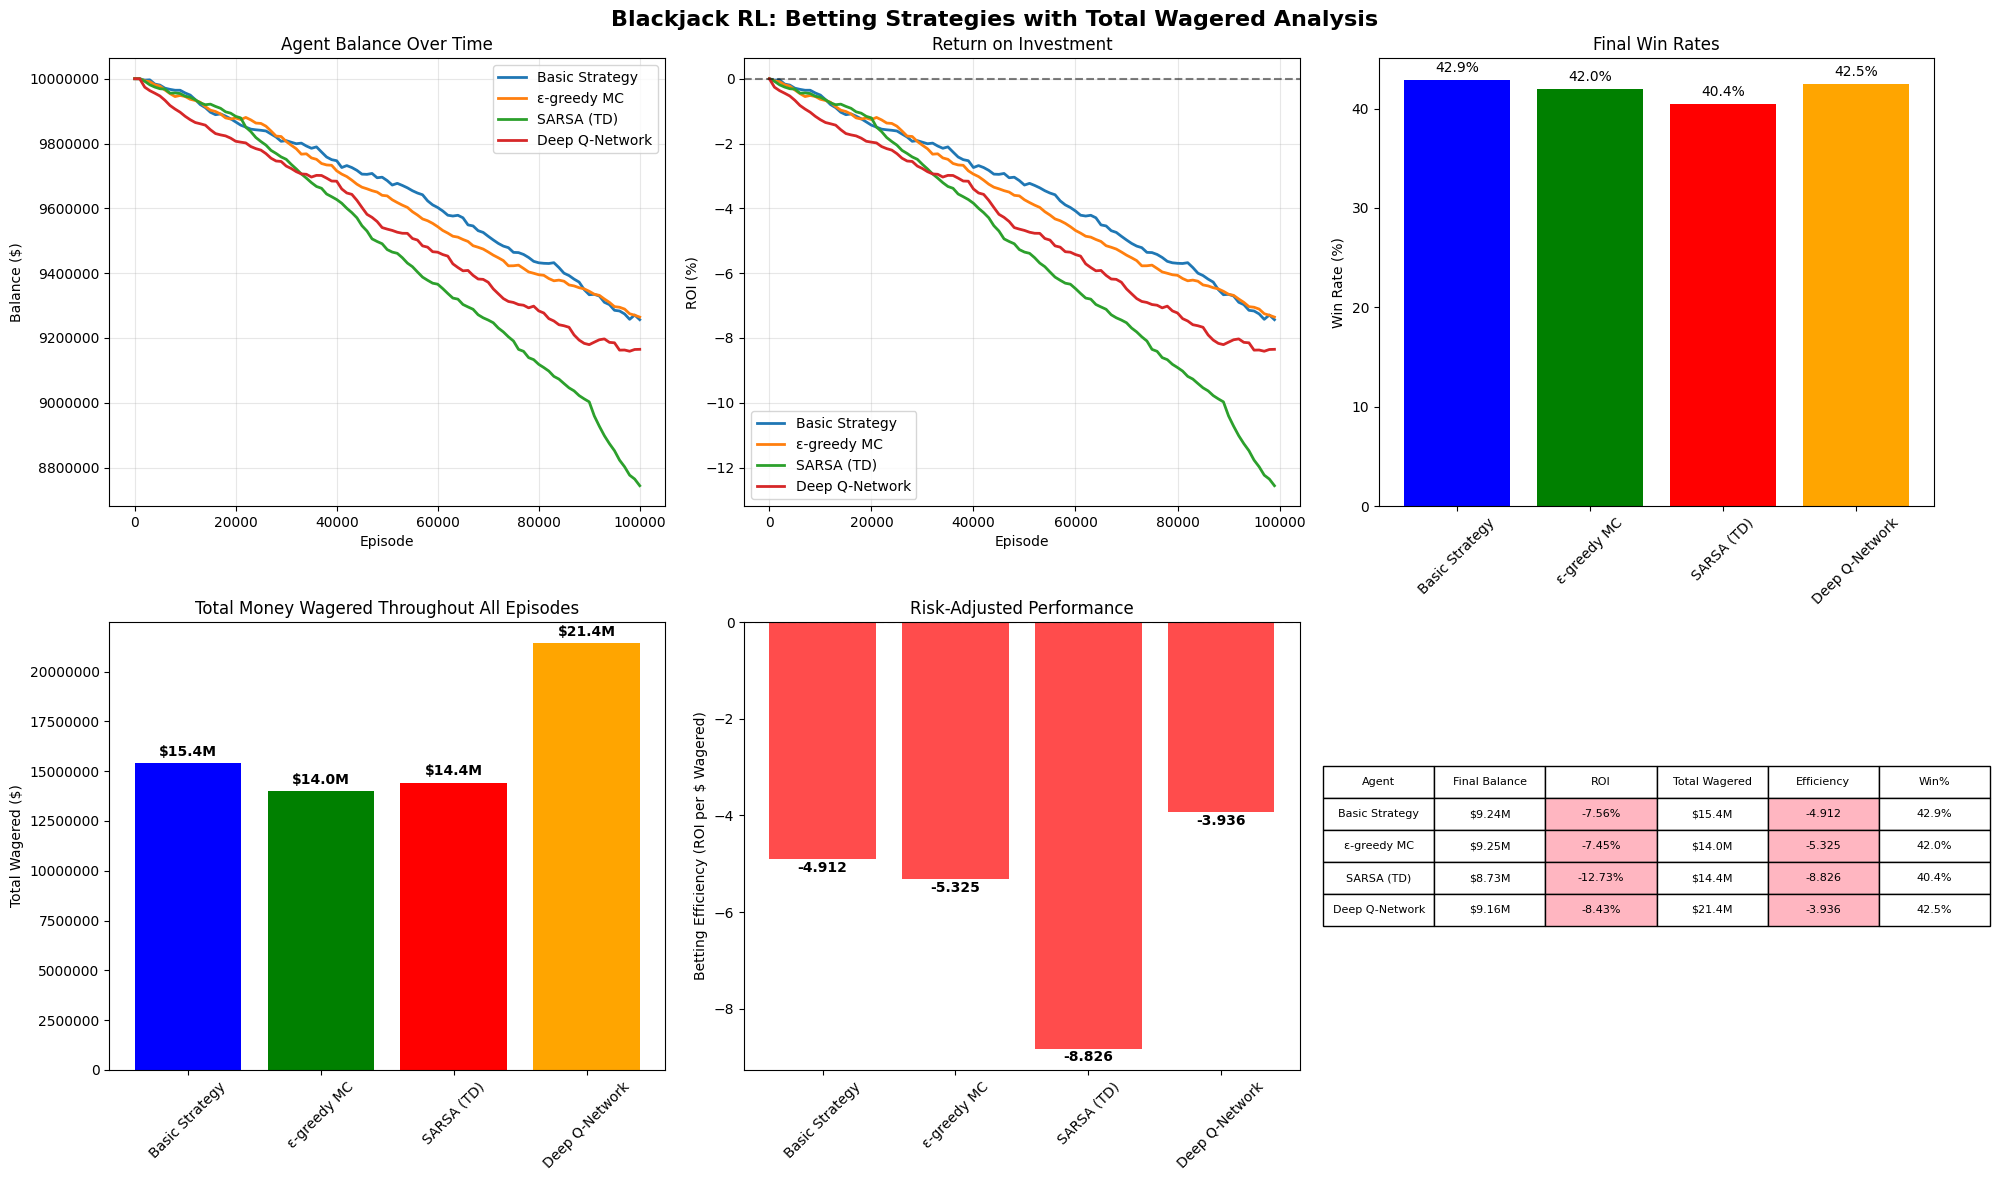


FINAL RESULTS - BETTING STRATEGIES

Agent Performance Summary:

Basic Strategy:
  Final Balance: $9,244,075
  ROI: -7.56%
  Total Wagered: $15,389,700
  Betting Efficiency: -4.9119
  Win Rate: 42.9%
  Games Played: 100,000
  W/L/P: 42,917/48,514/8,569
  Splits: 2,598
  Blackjacks: 5,035

ε-greedy MC:
  Final Balance: $9,254,790
  ROI: -7.45%
  Total Wagered: $13,995,855
  Betting Efficiency: -5.3245
  Win Rate: 42.0%
  Games Played: 100,000
  W/L/P: 41,989/49,134/8,877
  Splits: 4,653
  Blackjacks: 5,188
  Final Epsilon: 0.010000
  Q-Table: 882 states, 1,919 state-action pairs
  vs Basic Strategy: +0.11% ✓ OUTPERFORMED

SARSA (TD):
  Final Balance: $8,727,292
  ROI: -12.73%
  Total Wagered: $14,419,389
  Betting Efficiency: -8.8264
  Win Rate: 40.4%
  Games Played: 100,000
  W/L/P: 40,441/50,597/8,962
  Splits: 6,956
  Blackjacks: 5,495
  Final Epsilon: 0.010000
  Q-Table: 1,693 states, 3,805 state-action pairs
  vs Basic Strategy: -5.17% ✗ UNDERPERFORMED

Deep Q-Network:
  Final Bala

In [ ]:
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)

    print("🃏 Advanced Blackjack Reinforcement Learning")
    print("="*60)
    print("Initial Balance: $10,000,000 per agent")
    print("Maximum Bet: $2,000")
    print("\nAgents:")
    print("1. Basic Strategy")
    print("2. ε-greedy Monte Carlo (First-visit MC learning)")
    print("3. SARSA - TD Learning (On-policy learning)")
    print("4. Deep Q-Network (Neural network)")
    print("\n" + "="*60)

    # Train agents
    print("\n🚀 Starting training...")
    agents, history, env = train_agents(num_episodes=100000)

    # Visualize results
    print("\n📊 Generating visualizations...")
    visualize_results(agents, history)

    print("\n🎯 Training completed successfully!")